<a href="https://colab.research.google.com/github/marciosferreira/FasterRCNNTutorial/blob/master/embryo_auto_encoders_by_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational autoencoder and its extensions


---

This notebook demonstrates application of different variational autoencoders (VAEs) to rotated images. Specifically, we discuss rotationally invariant version of VAE (rVAE) and class-conditioned VAE and rVAE.

Prepared by Maxim Ziatdinov  (Feb 2021)

E-mail: maxim.ziatdinov@ai4microscopy.com

---



## Installation/Imports/Utility functions

*Make sure to click "Play" button for the next 4 cells ("Installation and Imports", "Load neural networks for VAE", etc.) to load all the necessary modules and functions!*

#@title Installation and Imports


In [58]:
#@title Installation and Imports

!pip install -qq pyro-ppl

from typing import Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
import torch
import torch.nn as nn
from torch import Tensor as tt
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings("ignore", module="torchvision.datasets")

from torchvision.transforms import ToPILImage


In [59]:
#@title Load functions for working with image coordinates and labels { form-width: "25%" }

def to_onehot(idx: torch.Tensor, n: int) -> torch.Tensor:


    """
    One-hot encoding of a label
    """
    #print("onehot")
    #print(idx)
    if torch.max(idx).item() >= n:
        raise AssertionError(
            "Labelling must start from 0 and "
            "maximum label value must be less than total number of classes")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if idx.dim() == 1:
        idx = idx.unsqueeze(1).long()
    onehot = torch.zeros(idx.size(0), n, device=device)
    #return onehot.scatter_(1, idx.to(device), 1)
    return onehot.scatter_(1, idx.long().to(device), 1)



def grid2xy(X1: torch.Tensor, X2: torch.Tensor) -> torch.Tensor:
    X = torch.cat((X1[None], X2[None]), 0)
    d0, d1 = X.shape[0], X.shape[1] * X.shape[2]
    X = X.reshape(d0, d1).T
    return X


def imcoordgrid(im_dim: Tuple) -> torch.Tensor:
    xx = torch.linspace(-1, 1, im_dim[0])
    yy = torch.linspace(1, -1, im_dim[1])
    x0, x1 = torch.meshgrid(xx, yy)
    return grid2xy(x0, x1)


def transform_coordinates(coord: torch.Tensor,
                          phi: Union[torch.Tensor, float] = 0,
                          coord_dx: Union[torch.Tensor, float] = 0,
                          ) -> torch.Tensor:

    if torch.sum(phi) == 0:
        phi = coord.new_zeros(coord.shape[0])
    rotmat_r1 = torch.stack([torch.cos(phi), torch.sin(phi)], 1)
    rotmat_r2 = torch.stack([-torch.sin(phi), torch.cos(phi)], 1)
    rotmat = torch.stack([rotmat_r1, rotmat_r2], axis=1)
    coord = torch.bmm(coord, rotmat)




    return coord + coord_dx

In [60]:
#@title Load neural networks for VAE { form-width: "25%" }

def set_deterministic_mode(seed: int) -> None:
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def make_fc_layers(in_dim: int,
                   hidden_dim: int = 128,
                   num_layers: int = 3,
                   activation: str = "lrelu"
                   ) -> Type[nn.Module]:
    """
    Generates a module with stacked fully-connected (aka dense) layers
    """
    in_dim=int(in_dim)


    activations = {
    "tanh": nn.Tanh,
    "lrelu": nn.LeakyReLU,
    "softplus": nn.Softplus,
    "linear": nn.Identity
}


    fc_layers = []

    for i in range(num_layers):
        hidden_dim_ = in_dim if i == 0 else hidden_dim
        fc_layers.extend(
            [nn.Linear(hidden_dim_, hidden_dim),
            activations[activation]()])


    fc_layers = nn.Sequential(*fc_layers)
    return fc_layers


class fcEncoderNet(nn.Module):
    """
    Simple fully-connected inference (encoder) network
    """
    def __init__(self,
                 in_dim: Tuple[int],
                 latent_dim: int = 4,
                 hidden_dim:int = 128,
                 num_layers: int = 3,
                 activation: str = 'lrelu',
                 softplus_out: bool = False
                 ) -> None:
        """
        Initializes module parameters
        """

        super(fcEncoderNet, self).__init__()


        if len(in_dim) not in [1, 2, 3]:
            raise ValueError("in_dim must be (h, w), (h, w, c), or (h*w*c,)")
        self.in_dim = torch.prod(tt(in_dim)).item()



        self.fc_layers = make_fc_layers(
        self.in_dim, hidden_dim, num_layers, activation)
        self.fc11 = nn.Linear(hidden_dim, latent_dim)
        self.fc12 = nn.Linear(hidden_dim, latent_dim)
        self.activation_out = nn.Softplus() if softplus_out else lambda x: x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        Forward pass
        """

        x = x.view(-1, int(self.in_dim))



        x = self.fc_layers(x)
        mu = self.fc11(x)
        log_sigma = self.activation_out(self.fc12(x))
        return mu, log_sigma


class fcDecoderNet(nn.Module):
    """
    Standard decoder for VAE
    """
    def __init__(self,
                 out_dim: Tuple[int],
                 latent_dim: int = 4,
                 hidden_dim:int = 128,
                 num_layers: int = 3,
                 activation: str = 'lrelu',
                 sigmoid_out: str = True,
                 ) -> None:
        super(fcDecoderNet, self).__init__()
        if len(out_dim) not in [1, 2, 3]:
            raise ValueError("in_dim must be (h, w), (h, w, c), or (h*w*c,)")


        self.reshape = out_dim
        out_dim = torch.prod(tt(out_dim)).item()
        self.fc_layers = make_fc_layers(
            latent_dim, hidden_dim, num_layers, activation)


        out_dim = int(out_dim)


        self.out = nn.Linear(hidden_dim, out_dim)

        self.activation_out = nn.Sigmoid() if sigmoid_out else lambda x: x

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        x = self.fc_layers(z)
        x = self.activation_out(self.out(x))
        return x.view(-1, *self.reshape)


class rDecoderNet(nn.Module):
    """
    Spatial generator (decoder) network with fully-connected layers
    """
    def __init__(self,
                 out_dim: Tuple[int],
                 latent_dim: int,
                 hidden_dim:int = 10,
                 num_layers: int = 10,
                 activation: str = 'lrelu',
                 sigmoid_out: str = True
                 ) -> None:
        """
        Initializes module parameters
        """

        super(rDecoderNet, self).__init__()
        if len(out_dim) not in [1, 2, 3]:
            raise ValueError("in_dim must be (h, w), (h, w, c), or (h*w*c,)")
        self.reshape = out_dim
        out_dim = torch.prod(tt(out_dim)).item()

        self.coord_latent = coord_latent(latent_dim, hidden_dim)
        self.fc_layers = make_fc_layers(
            hidden_dim, hidden_dim, num_layers, activation)

        self.out = nn.Linear(hidden_dim, 1) # need to generalize to multi-channel (c > 1)
        self.activation_out = nn.Sigmoid() if sigmoid_out else lambda x: x

    def forward(self, x_coord: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        """
        x = self.coord_latent(x_coord, z)
        x = self.fc_layers(x)
        x = self.activation_out(self.out(x))
        return x.view(-1, *self.reshape)


class coord_latent(nn.Module):
    """
    The "spatial" part of the rVAE's decoder that allows for translational
    and rotational invariance (based on https://arxiv.org/abs/1909.11663)
    """
    def __init__(self,
                 latent_dim: int,
                 out_dim: int,
                 activation_out: bool = True) -> None:
        """
        Iniitalizes modules parameters
        """
        super(coord_latent, self).__init__()
        self.fc_coord = nn.Linear(2, out_dim)
        self.fc_latent = nn.Linear(latent_dim, out_dim, bias=False)
        self.activation = nn.Tanh() if activation_out else None

    def forward(self,
                x_coord: torch.Tensor,
                z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        """
        batch_dim, n = x_coord.size()[:2]
        x_coord = x_coord.reshape(batch_dim * n, -1)
        h_x = self.fc_coord(x_coord)
        h_x = h_x.reshape(batch_dim, n, -1)
        h_z = self.fc_latent(z)
        h = h_x.add(h_z.unsqueeze(1))
        h = h.reshape(batch_dim * n, -1)
        if self.activation is not None:
            h = self.activation(h)
        return h

In [61]:
#@title Load utility functions for data loading and preprocessing
from PIL import Image
from torchvision.transforms import ToTensor

def get_rotated_mnist(rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    #!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
    #!tar -zxvf MNIST.tar.gz
    #mnist_trainset = datasets.MNIST(
        #root='.', train=True, download=False, transform=None)
    imstack_train_r = torch.zeros_like(train_data, dtype=torch.float32)
    labels, angles = [], []
    #for i, (im, lbl) in enumerate(tensor_images):
    for i, (im, lbl) in enumerate(zip(train_data, train_labels)):
        # Converta o tensor para uma imagem PIL
        im = ToPILImage()(im)
        theta = torch.randint(*rotation_range, (1,)).float()
        im = im.rotate(theta.item(), resample=Image.BICUBIC, fillcolor="white")
        imstack_train_r[i] = ToTensor()(im)
        labels.append(lbl)
        angles.append(torch.deg2rad(theta))
    imstack_train_r /= imstack_train_r.max()
    return imstack_train_r, tt(labels), tt(angles)


def init_dataloader(*args: torch.Tensor, **kwargs: int
                    ) -> Type[torch.utils.data.DataLoader]:

    batch_size = kwargs.get("batch_size", 100)
    tensor_set = torch.utils.data.dataset.TensorDataset(*args)
    data_loader = torch.utils.data.DataLoader(
        dataset=tensor_set, batch_size=batch_size, shuffle=True)
    return data_loader

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Get training data

In [63]:

!unzip -n /content/drive/My\ Drive/embryos_for_encoder.zip -d /content/



Archive:  /content/drive/My Drive/embryos_for_encoder.zip


Get rotated MNIST data and pass it to dataloader that will be used for (r)VAE training:

Plot samples from the rotated MNIST dataset:

In [64]:
import os
import re
import torch
from PIL import Image

# 1. Percorrer os arquivos .jpg de uma pasta e adicionar os nomes em uma lista
folder_path = '/content/embryos_for_encoder'  # Substitua pelo caminho da sua pasta
file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Mapeamento dos valores
#temp_mapping = {"21": 0, "28": 1, "35": 2}

# 2. Percorrer a lista de nomes e extrair a informação desejada
#pattern = re.compile(r'_(\d{2})C_')
#temperature_list = [temp_mapping[pattern.search(filename).group(1)] for filename in file_list if pattern.search(filename)]


# 3. Abrir cada imagem, convertê-la para escala de cinza, redimensioná-la para 56x56 e adicionar a uma lista
image_list = [Image.open(filename).convert('L').resize((28, 28)) for filename in file_list]    #28x28

# 4. Converter as listas resultantes em tensores do PyTorch
tensor_images = torch.stack([torch.tensor(np.array(img)) for img in image_list])
#tensor_temperatures = torch.tensor([int(temp) for temp in temperature_list])

print(tensor_images.shape)  # Deve ser algo como [número_de_imagens, 56, 56]
#print(tensor_temperatures.shape)  # Deve ser algo como [número_de_imagens]


torch.Size([2808, 128, 128])


In [65]:
#import pandas as pd
#/content/embryos_for_encoder/210614110923_OlE_HR_IPF2_BQ_2x_21C_medaka_bpm_out_v1.4_LOOP1_01.jpg

In [66]:
#df_final = pd.read_csv("/content/full_data_autoencoder.csv")

In [67]:
#df_final.loc[df_final["experiment_id"] == "210614110923_OlE_HR_IPF2_BQ_2x_21C"]

In [68]:
import os
import pandas as pd
import torch

# Carrega o DataFrame (assumindo que você já tenha isso)
df = pd.read_csv('/content/drive/My Drive/full_data_autoencoder.csv')

# Local da pasta que contém os arquivos
diretorio = '/content/embryos_for_encoder'

# Lista para armazenar os tensores
lista_tensores = []

for nome_arquivo in os.listdir(diretorio):
    if nome_arquivo.endswith('.jpg'):
        # Extrai as partes do nome do arquivo
        partes = nome_arquivo.split('_')

        experiment_id = '_'.join(partes[:partes.index('medaka')])

        if "LOOP1" in nome_arquivo:
            loop = "LO001"
        elif "LOOP2" in nome_arquivo:
            loop = "LO002"
        else:
            print(f"Arquivo {nome_arquivo} não tem LOOP1 ou LOOP2")
            continue

        well_id = "WE000" + nome_arquivo.split('_')[-1].split('.')[0].zfill(2)

        # Filtre o DataFrame
        filtro = (df['experiment_id'] == experiment_id) & (df['Loop'] == loop) & (df['WellID'] == well_id)

        linha_correspondente = df[filtro]

        # Crie um tensor PyTorch com o valor de "Heart size" e adicione-o à lista
        if not linha_correspondente.empty:
            valor = linha_correspondente['Heart size'].iloc[0]
            tensor = torch.tensor([valor])
            lista_tensores.append(tensor)
        else:
            print(f"Nenhuma linha correspondente encontrada para o arquivo {nome_arquivo}")

# Se você quiser criar um tensor único a partir da lista de tensores:
tensor_final = torch.cat(lista_tensores)
print(tensor_final)



tensor([8496., 6336.,   nan,  ...,  446., 4210., 5849.], dtype=torch.float64)


In [69]:
#import torch



# Defina os limites para as categorias
# Supondo que os valores vão de 0 a 5, e você quer dividi-los em 5 classes
limites = torch.tensor([2500, 5000, 7500, 10000, 15000])

# Use torch.bucketize para categorizar os valores
#categorias = torch.bucketize(tensor_final, limites)
categorias = tensor_final.clamp(max=10000)

categorias[torch.isnan(categorias)] = 0


# Transformar NaNs em 0 e todos os outros valores em 1
#categorias = torch.where(torch.isnan(categorias), torch.tensor(0.0), torch.tensor(1.0))

print(categorias)


tensor([8496., 6336.,    0.,  ...,  446., 4210., 5849.], dtype=torch.float64)


In [70]:
hhhh

NameError: ignored

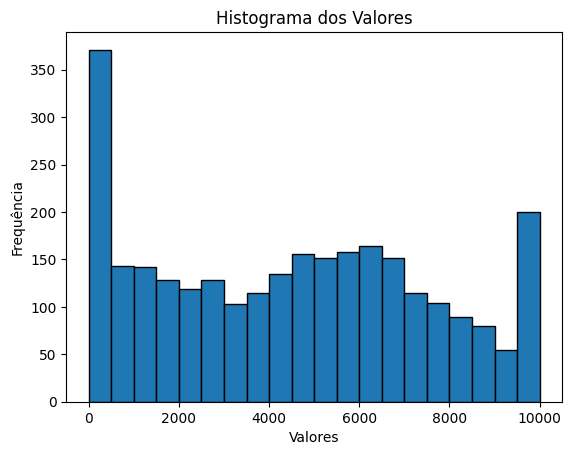

In [71]:
# Converta o tensor para numpy para plotagem
data_numpy = categorias.numpy()

# Plote o histograma
plt.hist(data_numpy, bins=20, edgecolor='black')  # você pode ajustar o número de bins conforme necessário
plt.title('Histograma dos Valores')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

In [72]:
import torch

images_per_class = 100

def create_image_array(original_images):
    """
    Esta função seleciona as 4 primeiras imagens de um tensor de imagens e cria um novo tensor
    com 250 cópias de cada uma dessas imagens, totalizando 1000 imagens.

    :param original_images: Tensor de imagens (onde cada imagem é representada por um sub-tensor)
    :return: Novo tensor com 1000 imagens, sendo 250 cópias de cada uma das 4 primeiras imagens do tensor original,
             e um tensor de índices indicando a origem de cada imagem.
    """
    # Verifica se o tensor original_images não está vazio e tem pelo menos 4 imagens
    if original_images.size(0) < 10:
        raise ValueError("O tensor de imagens original deve conter pelo menos 4 imagens.")

    # Seleciona as 4 primeiras imagens do tensor original
    first_images = original_images[:1000]

    # Cria um novo tensor com 250 cópias de cada uma das 4 primeiras imagens
    new_images = torch.cat([img.unsqueeze(0).repeat(images_per_class, 1, 1) for img in first_images], dim=0)

    # Cria um tensor de índices que indica a qual das 4 imagens originais cada uma das 1000 imagens pertence
    indices = torch.arange(50).repeat_interleave(images_per_class)

    return new_images, indices

new_images, indices = create_image_array(tensor_images) # commented just for tests

new_images = tensor_images # just for test


In [ ]:
indices

tensor([2347, 2658, 2223, 1860, 2435, 1715,  113,  417,  431, 1285])


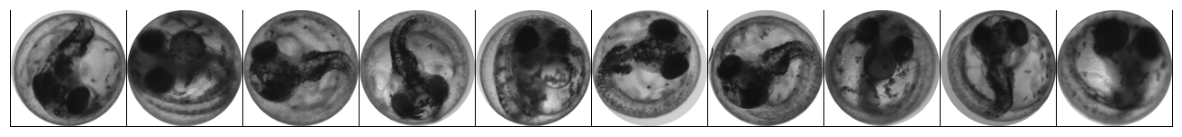

In [73]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Vamos assumir que 'categorias' e 'new_images' são os tensores já definidos anteriormente.

# Criar uma máscara para valores que não são 0
mask = categorias != 0

# Obtenha os índices não-zero do tensor categorias
non_zero_indices = torch.nonzero(mask).squeeze()

# Use esses índices não-zero para indexar o tensor categorias
filtered_values = categorias[non_zero_indices]

# Obter os índices dos 100 menores valores do tensor filtrado
values, top_indices = torch.topk(filtered_values, 10, largest=False)

# Use os índices não-zero originais filtrados por esses 100 menores índices
# para obter os índices corretos no tensor original
selected_indices = non_zero_indices[top_indices]

# Selecionar as imagens correspondentes com base nos índices originais
selected_images = new_images[selected_indices]

print(selected_indices)

top_images = selected_images.unsqueeze(1)  # Adiciona uma dimensão extra para o canal

# Exibindo as imagens em uma grade 10x10:
grid_img = make_grid(top_images, nrow=10, padding=1)
grid_img = grid_img.float() / 255.0

plt.figure(figsize=(15, 15))
plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()


# menores

tensor([ 67,  21,  30,  94, 141,  95, 144, 180, 145,  16])


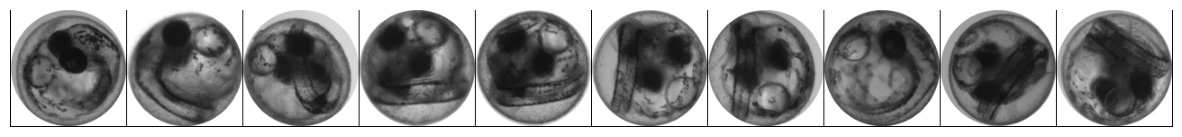

In [74]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Vamos assumir que 'categorias' e 'new_images' são os tensores já definidos anteriormente.

# Criar uma máscara para valores que não são 0
mask = categorias != 0

# Obtenha os índices não-zero do tensor categorias
non_zero_indices = torch.nonzero(mask).squeeze()

# Use esses índices não-zero para indexar o tensor categorias
filtered_values = categorias[non_zero_indices]

# Obter os índices dos 100 menores valores do tensor filtrado
values, top_indices = torch.topk(filtered_values, 10, largest=True)

# Use os índices não-zero originais filtrados por esses 100 menores índices
# para obter os índices corretos no tensor original
selected_indices = non_zero_indices[top_indices]

print(selected_indices)
# Selecionar as imagens correspondentes com base nos índices originais
selected_images = new_images[selected_indices]

top_images = selected_images.unsqueeze(1)  # Adiciona uma dimensão extra para o canal

# Exibindo as imagens em uma grade 10x10:
grid_img = make_grid(top_images, nrow=10, padding=1)
grid_img = grid_img.float() / 255.0

plt.figure(figsize=(15, 15))
plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()


# maiores

## Define model and trainer

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Vamos assumir que 'categorias' e 'new_images' são os tensores já definidos anteriormente.

# Criar uma máscara para valores que não são 0
mask = categorias == 0

# Obtenha os índices não-zero do tensor categorias
zero_indices = torch.nonzero(mask).squeeze()

# Use esses índices não-zero para indexar o tensor categorias
filtered_values = categorias[zero_indices]

# Obter os índices dos 100 menores valores do tensor filtrado
values, top_indices = torch.topk(filtered_values, 100, largest=True)

# Use os índices não-zero originais filtrados por esses 100 menores índices
# para obter os índices corretos no tensor original
selected_indices = zero_indices[top_indices]

# Selecionar as imagens correspondentes com base nos índices originais
selected_images = new_images[selected_indices]

top_images = selected_images.unsqueeze(1)  # Adiciona uma dimensão extra para o canal

# Exibindo as imagens em uma grade 10x10:
grid_img = make_grid(top_images, nrow=10, padding=1)
grid_img = grid_img.float() / 255.0

plt.figure(figsize=(15, 15))
plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()


# zero

In [ ]:
plt.imshow(new_images[2], cmap='gray')  # cmap é o mapa de cores, 'gray' é escala de cinza
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Defina o caminho da sua imagem
image_path = file_list[95]
print(file_list[95])

# Carregue a imagem
img = mpimg.imread(image_path)

# Exiba a imagem
plt.imshow(img)
plt.axis('off')  # Para ocultar os eixos
plt.show()


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Defina o caminho da sua imagem
image_path = file_list[1860]
print(file_list[1860])

# Carregue a imagem
img = mpimg.imread(image_path)

# Exiba a imagem
plt.imshow(img)
plt.axis('off')  # Para ocultar os eixos
plt.show()





Next, we define our rVAE as a probabilistic model. To do this, first, we define our generative model (aka decoder) whose goal is to reconstruct observations (images) from the latent "code". Then we write an appropriate *guide* function (aka encoder) whose job is to ‘guess’ good values for the latent random variables. We are also going to add some helper functions to the rVAE class for the encoding of images and visualization of the learned latent manifold so that we do not have to write them over and over again.

In [ ]:
vvvv

In [ ]:
train_data = new_images
train_labels = categorias


In [ ]:
train_labels
train_labels = train_labels.to(dtype=torch.int64)


In [ ]:
train_data, train_labels, angles = get_rotated_mnist(rotation_range=[-60, 61])   #-60, 61
train_loader = init_dataloader(train_data, batch_size=100)

In [ ]:
import torch
from torch import Tensor as tt

tensor_val = tt(torch.Size([28, 28]))
prod_val = torch.prod(tensor_val)


In [ ]:
class rVAE(nn.Module):
    """
    Variational autoencoder with rotational and/or transaltional invariance
    """
    def __init__(self,
                 in_dim: Tuple[int],
                 latent_dim: int = 4,
                 coord: int = 3,
                 num_classes: int = 0,
                 hidden_dim_e: int = 128,
                 hidden_dim_d: int = 128,
                 num_layers_e: int = 2,
                 num_layers_d: int = 2,
                 activation: str = "lrelu",
                 softplus_sd: bool = True,
                 sigmoid_out: bool = True,
                 seed: int = 1,
                 **kwargs
                 ) -> None:
        """
        Initializes rVAE's modules and parameters
        """

        super(rVAE, self).__init__()
        pyro.clear_param_store()
        set_deterministic_mode(seed)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'


        self.encoder_net = fcEncoderNet(
            in_dim, latent_dim+coord, hidden_dim_e,
            num_layers_e, activation, softplus_sd)
        if coord not in [0, 1, 2, 3]:
            raise ValueError("'coord' argument must be 0, 1, 2 or 3")
        dnet = rDecoderNet if coord in [1, 2, 3] else fcDecoderNet


        self.decoder_net = dnet(
            in_dim, latent_dim+num_classes, hidden_dim_d,
            num_layers_d, activation, sigmoid_out)
        self.z_dim = latent_dim + coord
        self.coord = coord
        self.num_classes = num_classes
        self.grid = imcoordgrid(in_dim).to(self.device)

        #self.dx_prior = tt(kwargs.get("dx_prior", 0.1)).to(self.device)
        self.dx_prior = tt([kwargs.get("dx_prior", 0.1)]).to(self.device)



        self.to(self.device)


    def model(self,
              x: torch.Tensor,
              y: Optional[torch.Tensor] = None,
              **kwargs: float) -> torch.Tensor:
        """
        Defines the model p(x|z)p(z)
        """
        # register PyTorch module `decoder_net` with Pyro
        pyro.module("decoder_net", self.decoder_net)
        # KLD scale factor (see e.g. https://openreview.net/pdf?id=Sy2fzU9gl)
        beta = kwargs.get("scale_factor", 0.1)
        #reshape_ = torch.prod(tt(x.shape[1:])).item()
        #reshape_ = torch.prod(tt(torch.Size([28, 28])))
        reshape_ = x.shape[1:][0] * x.shape[1:][1]

        ####################################################

        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            with pyro.poutine.scale(scale=beta):
                z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            if self.coord > 0:  # rotationally- and/or translationaly-invariant mode
                # Split latent variable into parts for rotation
                # and/or translation and image content
                phi, dx, z = self.split_latent(z)
                if torch.sum(dx) != 0:
                    dx = (dx * self.dx_prior).unsqueeze(1)
                # transform coordinate grid
                grid = self.grid.expand(x.shape[0], *self.grid.shape)
                x_coord_prime = transform_coordinates(grid, phi, dx)
            # Add class label (if any)
            if y is not None:
                y = to_onehot(y, self.num_classes)
                z = torch.cat([z, y], dim=-1)
            # decode the latent code z together with the transformed coordiantes (if any)
            dec_args = (x_coord_prime, z) if self.coord else (z,)
            loc_img = self.decoder_net(*dec_args)
            # score against actual images ("binary cross-entropy loss")

            pyro.sample(
                "obs", dist.Bernoulli(loc_img.view(-1, int(reshape_)), validate_args=False).to_event(1),
                obs=x.view(-1, reshape_))

    def guide(self,
              x: torch.Tensor,
              y: Optional[torch.Tensor] = None,
              **kwargs: float) -> torch.Tensor:
        """
        Defines the guide q(z|x)
        """
        # register PyTorch module `encoder_net` with Pyro
        pyro.module("encoder_net", self.encoder_net)
        # KLD scale factor (see e.g. https://openreview.net/pdf?id=Sy2fzU9gl)
        beta = kwargs.get("scale_factor", 0.1)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder_net(x)
            # sample the latent code z
            with pyro.poutine.scale(scale=beta):
                pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def split_latent(self, z: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        Split latent variable into parts for rotation
        and/or translation and image content
        """
        phi = torch.tensor(0.0)
        dx = torch.tensor(0.0)


        # rotation + translation
        if self.coord == 3:
            phi = z[:, 0]  # encoded angle
            dx = z[:, 1:3]  # translation
            z = z[:, 3:]  # image content
        # translation only
        elif self.coord == 2:
            dx = z[:, :2]
            z = z[:, 2:]
        # rotation only
        elif self.coord == 1:
            phi = z[:, 0]
            z = z[:, 1:]
        return phi, dx, z

    def _encode(self, x_new: torch.Tensor, **kwargs: int) -> torch.Tensor:
        """
        Encodes data using a trained inference (encoder) network
        in a batch-by-batch fashion
        """
        def inference() -> np.ndarray:
            with torch.no_grad():
                encoded = self.encoder_net(x_i)
                print("encoded")
                print(encoded)
            encoded = torch.cat(encoded, -1).cpu()
            print("the encoded")
            print(encoded.shape)
            return encoded

        x_new = x_new.to(self.device)
        num_batches = kwargs.get("num_batches", 10)
        batch_size = len(x_new) // num_batches
        z_encoded = []
        for i in range(num_batches):
            x_i = x_new[i*batch_size:(i+1)*batch_size]
            z_encoded_i = inference()
            z_encoded.append(z_encoded_i)
        x_i = x_new[(i+1)*batch_size:]
        if len(x_i) > 0:
            z_encoded_i = inference()
            z_encoded.append(z_encoded_i)
            conc = torch.cat(z_encoded)
            print("the shaaaape")
            print(conc.shape)
        return conc

    def encode(self, x_new: torch.Tensor, **kwargs: int) -> torch.Tensor:
        """
        Encodes data using a trained inference (encoder) network
        (this is baiscally a wrapper for self._encode)
        """
        if isinstance(x_new, torch.utils.data.DataLoader):
            x_new = train_loader.dataset.tensors[0]
        z = self._encode(x_new)


        print("the zzzzzzzzz")
        print(z.shape)
        z_loc = z[:, :self.z_dim]
        z_scale = z[:, self.z_dim:]
        return z_loc, z_scale

    def manifold2d(self, d: int, **kwargs: Union[str, int]) -> torch.Tensor:
        """
        Plots a learned latent manifold in the image space
        """
        print("manifold2d")
        print(print(kwargs))
        print("n classes")
        print(self.num_classes)
        if self.num_classes > 0:
            #cls = tt(kwargs.get("label", 0))
            cls = torch.tensor(kwargs.get("label", 0))



            print("the cls")
            print(cls)
            cls = to_onehot(cls.unsqueeze(0), self.num_classes)
            print(cls)
        grid_x = norm.ppf(torch.linspace(0.95, 0.05, d))
        grid_y = norm.ppf(torch.linspace(0.05, 0.95, d))
        print("point 100")
        loc_img_all = []
        for i, xi in enumerate(grid_x):
            for j, yi in enumerate(grid_y):
                z_sample = tt([xi, yi]).float().to(self.device).unsqueeze(0)
                if self.num_classes > 0:
                    z_sample = torch.cat([z_sample, cls], dim=-1)
                d_args = (self.grid.unsqueeze(0), z_sample) if self.coord > 0 else (z_sample,)
                loc_img = self.decoder_net(*d_args)
                loc_img_all.append(loc_img.detach().cpu())
        loc_img_all = torch.cat(loc_img_all)

        grid = make_grid(loc_img_all[:, None], nrow=d,
                         padding=kwargs.get("padding", 2),
                         pad_value=kwargs.get("pad_value", 0))
        plt.figure(figsize=(8, 8))
        plt.imshow(grid[0], cmap=kwargs.get("cmap", "gnuplot"),
                   origin=kwargs.get("origin", "upper"),
                   extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("$z_1$", fontsize=18)
        plt.ylabel("$z_2$", fontsize=18)
        plt.show()

        import random

    def manifold2d_diff(self, d: int, train_data_latent, train_data, **kwargs: Union[str, int]) -> torch.Tensor:

        print("manifold2d")
        print(print(kwargs))
        print("n classes")
        print(self.num_classes)

        if self.num_classes > 0:
            cls = torch.tensor(kwargs.get("label", 0))
            cls = to_onehot(cls.unsqueeze(0), self.num_classes)
            print("the cls")
            print(cls)

        grid_x = norm.ppf(torch.linspace(0.95, 0.05, d))
        grid_y = norm.ppf(torch.linspace(0.05, 0.95, d))
        print("point 100")

        loc_img_all = []
        nearest_train_imgs = []

        for i, xi in enumerate(grid_x):
            for j, yi in enumerate(grid_y):
                z_sample = tt([xi, yi]).float().to(self.device).unsqueeze(0)

                if self.num_classes > 0:
                    z_sample = torch.cat([z_sample, cls], dim=-1)

                d_args = (self.grid.unsqueeze(0), z_sample) if self.coord > 0 else (z_sample,)
                loc_img = self.decoder_net(*d_args)
                loc_img_all.append(loc_img.detach().cpu())

                # Encontre a imagem de treino mais próxima
                z_sample_rep = z_sample.repeat(len(train_data_latent), 1)

                train_data_latent = train_data_latent.to('cuda:0')
                z_sample_rep = z_sample_rep.to('cuda:0')


                distances = torch.norm(train_data_latent - z_sample_rep, dim=1)
                nearest_idx = torch.argmin(distances)
                nearest_train_imgs.append(train_data[nearest_idx])

        nearest_train_imgs = torch.stack(nearest_train_imgs)
        loc_img_all = torch.cat(loc_img_all)

        # Plot das imagens geradas
        grid_gen = make_grid(loc_img_all[:, None], nrow=d, padding=kwargs.get("padding", 2), pad_value=kwargs.get("pad_value", 0))
        # Plot das imagens de treino mais próximas
        grid_train = make_grid(nearest_train_imgs[:, None], nrow=d, padding=kwargs.get("padding", 2), pad_value=kwargs.get("pad_value", 0))

        # Mostre as duas grids lado a lado
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        axes[0].imshow(grid_gen[0], cmap=kwargs.get("cmap", "gnuplot"), origin=kwargs.get("origin", "upper"), extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])
        axes[1].imshow(grid_train[0], cmap=kwargs.get("cmap", "gnuplot"), origin=kwargs.get("origin", "upper"), extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])
        plt.show()

        return grid_gen, grid_train




    def random_samples_from_latent(self, num_samples: int, **kwargs: Union[str, int]) -> torch.Tensor:
        """
        Generate and visualize reconstructions from random samples in the 3D latent space.
        """

        loc_img_all = []

        # Amostragem aleatória de num_samples pontos no espaço latente 3D
        for _ in range(num_samples):
            xi, yi, zi = [norm.ppf(random.random()) for _ in range(3)]
            z_sample = tt([xi, yi, zi]).float().to(self.device).unsqueeze(0)

            if self.num_classes > 0:
                z_sample = torch.cat([z_sample, cls], dim=-1)

            d_args = (self.grid.unsqueeze(0), z_sample) if self.coord > 0 else (z_sample,)
            loc_img = self.decoder_net(*d_args)
            loc_img_all.append(loc_img.detach().cpu())

        loc_img_all = torch.cat(loc_img_all)
        grid = make_grid(loc_img_all[:, None], nrow=int(num_samples**0.5),
                        padding=kwargs.get("padding", 2),
                        pad_value=kwargs.get("pad_value", 0))

        plt.figure(figsize=(10, 10))
        plt.imshow(grid[0], cmap=kwargs.get("cmap", "gnuplot"))
        plt.axis('off')
        plt.show()



We also define a stochastic variational inference (SVI) trainer for model training and evaluation:

In [ ]:
class SVItrainer:
    """
    Stochastic variational inference (SVI) trainer for
    unsupervised and class-conditioned variational models
    """
    def __init__(self,
                 model: Type[nn.Module],
                 optimizer: Type[optim.PyroOptim] = None,
                 loss: Type[infer.ELBO] = None,
                 seed: int = 1
                 ) -> None:
        """
        Initializes the trainer's parameters
        """
        pyro.clear_param_store()
        set_deterministic_mode(seed)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if optimizer is None:
            optimizer = optim.Adam({"lr": 1.0e-3})
        if loss is None:
            loss = infer.Trace_ELBO()
        self.svi = infer.SVI(model.model, model.guide, optimizer, loss=loss)
        self.loss_history = {"training_loss": [], "test_loss": []}
        self.current_epoch = 0

    def train(self,
              train_loader: Type[torch.utils.data.DataLoader],
              **kwargs: float) -> float:
        """
        Trains a single epoch
        """
        # initialize loss accumulator
        epoch_loss = 0.
        # do a training epoch over each mini-batch returned by the data loader
        for data in train_loader:
            if len(data) == 1:  # VAE mode
                x = data[0]
                loss = self.svi.step(x.to(self.device), **kwargs)
            else:  # VED or cVAE mode
                x, y = data
                loss = self.svi.step(
                    x.to(self.device), y.to(self.device), **kwargs)
            # do ELBO gradient and accumulate loss
            epoch_loss += loss

        return epoch_loss / len(train_loader.dataset)

    def evaluate(self,
                 test_loader: Type[torch.utils.data.DataLoader],
                 **kwargs: float) -> float:
        """
        Evaluates current models state on a single epoch
        """
        # initialize loss accumulator
        test_loss = 0.
        # compute the loss over the entire test set
        with torch.no_grad():
            for data in test_loader:
                if len(data) == 1:  # VAE mode
                    x = data[0]
                    loss = self.svi.step(x.to(self.device), **kwargs)
                else:  # VED or cVAE mode
                    x, y = data
                    loss = self.svi.step(
                        x.to(self.device), y.to(self.device), **kwargs)
                test_loss += loss

        return test_loss / len(test_loader.dataset)

    def step(self,
             train_loader: Type[torch.utils.data.DataLoader],
             test_loader: Optional[Type[torch.utils.data.DataLoader]] = None,
             **kwargs: float) -> None:
        """
        Single training and (optionally) evaluation step
        """
        self.loss_history["training_loss"].append(self.train(train_loader,**kwargs))
        if test_loader is not None:
            self.loss_history["test_loss"].append(self.evaluate(test_loader,**kwargs))
        self.current_epoch += 1

    def print_statistics(self) -> None:
        """
        Prints training and test (if any) losses for current epoch
        """
        e = self.current_epoch
        if len(self.loss_history["test_loss"]) > 0:
            template = 'Epoch: {} Training loss: {:.4f}, Test loss: {:.4f}'
            print(template.format(e, self.loss_history["training_loss"][-1],
                                  self.loss_history["test_loss"][-1]))
        else:
            template = 'Epoch: {} Training loss: {:.4f}'
            print(template.format(e, self.loss_history["training_loss"][-1]))


## **Verify original images**

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_tensor_images(tensor_images, num_images=64):
    """
    Função para plotar imagens a partir de um tensor do PyTorch.

    Argumentos:
    - tensor_images (torch.Tensor): Tensor de imagens no formato [N, H, W].
    - num_images (int): Número de imagens para plotar.

    """
    # Verifica se o tensor_images está no formato adequado
    if len(tensor_images.shape) != 3:
        raise ValueError("O tensor deve ter o formato [N, H, W].")

    N, H, W = tensor_images.shape

    # Cria um grid para exibir as imagens
    grid_size = int(np.sqrt(num_images))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(6, 6))

    for i in range(grid_size * grid_size):
        ax = axs[i // grid_size, i % grid_size]
        # Transforma o tensor em numpy
        img_np = tensor_images[i].cpu().numpy()
        ax.imshow(img_np, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Exemplo de uso:
# Cria um tensor fictício de 2808 imagens grayscale 28x28
sample_tensor = torch.randn(2808, 28, 28)

# Plotando as primeiras 64 imagens
plot_tensor_images(tensor_images)

## Train different VAE models

### Train vanilla VAE

In [ ]:
hhh

Train VAE model:

In [ ]:
train_loader = init_dataloader(train_data, batch_size=100)

In [ ]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (coord=0: vanilla VAE
#  coord=1: rotations only
#  coord=2: translations only
#  coord=3: rotations+translations)
vae = rVAE(in_dim, latent_dim=2, coord=0, seed=0)

# Initialize SVI trainer
trainer = SVItrainer(vae)
# Train for n epochs:
for e in range(2000):
    trainer.step(train_loader)
    trainer.print_statistics()

Visualize the learned manifold:

In [ ]:
fff

In [ ]:
vae.manifold2d(d=20, cmap='gray')

Encode all the data and view the encoded values as a scatter plot:

(note that we adjusted the orientations of the scatter plots and the manifold image such that digits look normal (and not upside down) to a human eye)

In [ ]:
z_mean, z_sd = vae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,1], z_mean[:,0], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,1], z_mean[:,0], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

### Train class-conditioned VAE (cVAE)

Reinitalize dataloader, now with labels for each training sample:

In [ ]:
import random


In [ ]:
vae.random_samples_from_latent(num_samples=30, d=10, cmap='gray')

In [ ]:
train_loader = init_dataloader(train_data, train_labels, batch_size=100)

Train cVAE model:

In [ ]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (coord=0: vanilla VAE
#  coord=1: rotations only
#  coord=2: translations only
#  coord=3: rotations+translations)
cvae = rVAE(in_dim, latent_dim=4, num_classes=10, coord=0, seed=0)
# Initialize SVI trainer
trainer = SVItrainer(cvae)


# Train for n epochs:
for e in range(2000):
    trainer.step(train_loader)
    trainer.print_statistics()

View the learned manifolds for each class:

In [ ]:
for i in range(5):
    cvae.manifold2d(d=6, label=i, cmap='gray')

Encode all the data and view the encoded values as a scatter plot:

In [ ]:
z_mean, z_sd = cvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,1], z_mean[:,0], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,1], z_mean[:,0], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

### Train rotationally-invariant VAE (rVAE)

Re-initialize dataloader:

In [ ]:
train_loader = init_dataloader(train_data, batch_size=100)

In [ ]:
###################################################################################################

Train rVAE:

In [ ]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (coord=0: vanilla VAE
#  coord=1: rotations only
#  coord=2: translations only
#  coord=3: rotations+translations)
rvae = rVAE(in_dim, latent_dim=2, coord=1, seed=0)

# Initialize SVI trainer
trainer = SVItrainer(rvae)
# Train for n epochs:
for e in range(2000):
    # Scale factor balances the qualitiy of reconstruction with the quality of disentanglement
    # It is optional, and the rvae will also work without it
    trainer.step(train_loader)
    trainer.print_statistics()

View the learned manifold:

In [ ]:
#rvae.random_samples_from_latent(num_samples=25, d=3, cmap='gray')

In [ ]:
train_data.shape

In [ ]:
train_data.shape

In [ ]:
z_mean, _ = rvae.encode(train_data)
z_mean = z_mean[:, 1:]



In [ ]:
z_mean.shape



In [ ]:
#    def manifold2d_diff(self, d: int, train_data_latent, train_data, **kwargs: Union[str, int]) -> torch.Tensor:


In [ ]:
import torch
import torch.nn.functional as F
import math

# Função para criar uma matriz de rotação 2D
def get_rotation_matrix(theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)

    # Criando a matriz de rotação para cada ângulo no tensor theta
    rotation_matrices = torch.stack([
        cos_theta, -sin_theta, torch.zeros_like(theta),
        sin_theta, cos_theta, torch.zeros_like(theta)
    ], dim=1).reshape(-1, 2, 3)

    return rotation_matrices

# Função para aplicar rotação a um batch de imagens

def rotate_images(images, angles):
    # Convertendo as imagens para float, se necessário
    images = images.float()

    # Ajustando as dimensões das imagens, se necessário
    if len(images.shape) == 3:
        images = images.unsqueeze(1)

    # Calculando a matriz de rotação
    rotation_matrices = get_rotation_matrix(angles).to(images.device)

    # Criando a grid para aplicar a transformação
    grid = F.affine_grid(rotation_matrices, images.size())

    # Aplicando a rotação
    rotated_images = F.grid_sample(images, grid)

    return rotated_images



images = tensor_images
angles = z_mean[:, 0]

rotated_images = rotate_images(images, angles)


In [ ]:
rotated_images = rotated_images.squeeze(1)


In [ ]:
rotated_images.shape

In [ ]:
rvae.manifold2d_diff(5, z_mean, rotated_images, cmap="gray")

Encode all the data and view the encoded values as a scatter plot:

(note that we adjusted the orientations of the scatter plots and the manifold image such that digits look normal (and not upside down) to a human eye)

In [ ]:
z_mean, z_sd = rvae.encode(train_data)
fig, ax = plt.subplots(figsize =(14, 9))

im = ax.scatter(z_mean[:,2], z_mean[:,1], c=train_labels, s=1, cmap='plasma', vmin=0, vmax=10000) # Você pode adicionar vmin e vmax se necessário
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)

cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

plt.show()


Plot true angles vs. encoded angles:

In [ ]:
# Mascara os NaNs e depois obtém o valor máximo
max_value = np.nanmax(train_labels)

print(max_value)

In [ ]:
# Converta o tensor para numpy para plotagem
train_labels = categorias.numpy()

# Plote o histograma
plt.hist(data_numpy, bins=20, edgecolor='black')  # você pode ajustar o número de bins conforme necessário
plt.title('Histograma dos Valores')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Encoded angle", fontsize=14)
ax = sns.histplot(x=angles, y=z_mean[:, 0], bins=50, pthresh=.1);

### Train class-conditioned rVAE (crVAE)

Reinitialize dataloader:

In [ ]:
train_loader = init_dataloader(train_data, train_labels, batch_size=100)

Train crVAE model:

In [ ]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (coord=0: vanilla VAE
#  coord=1: rotations only
#  coord=2: translations only
#  coord=3: rotations+translations)
crvae = rVAE(in_dim, latent_dim=4, num_classes=10, coord=1, seed=0) # scale_factor

# Initialize SVI trainer
trainer = SVItrainer(crvae)
# Train for n epochs:
for e in range(600):
    # Scale factor balances the qualitiy of reconstruction with the quality of disentanglement
    # It is optional, and the crvae will also work without it
    trainer.step(train_loader)
    trainer.print_statistics()

View the learned manifold for each class:

In [ ]:
for i in range(10):
    crvae.manifold2d(d=6, label=i, cmap="viridis")

Encode all the data and view the encoded values as a scatter plot:

In [ ]:
z_mean, z_sd = crvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10)